Found 1656 images belonging to 6 classes.
Found 72 images belonging to 6 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━

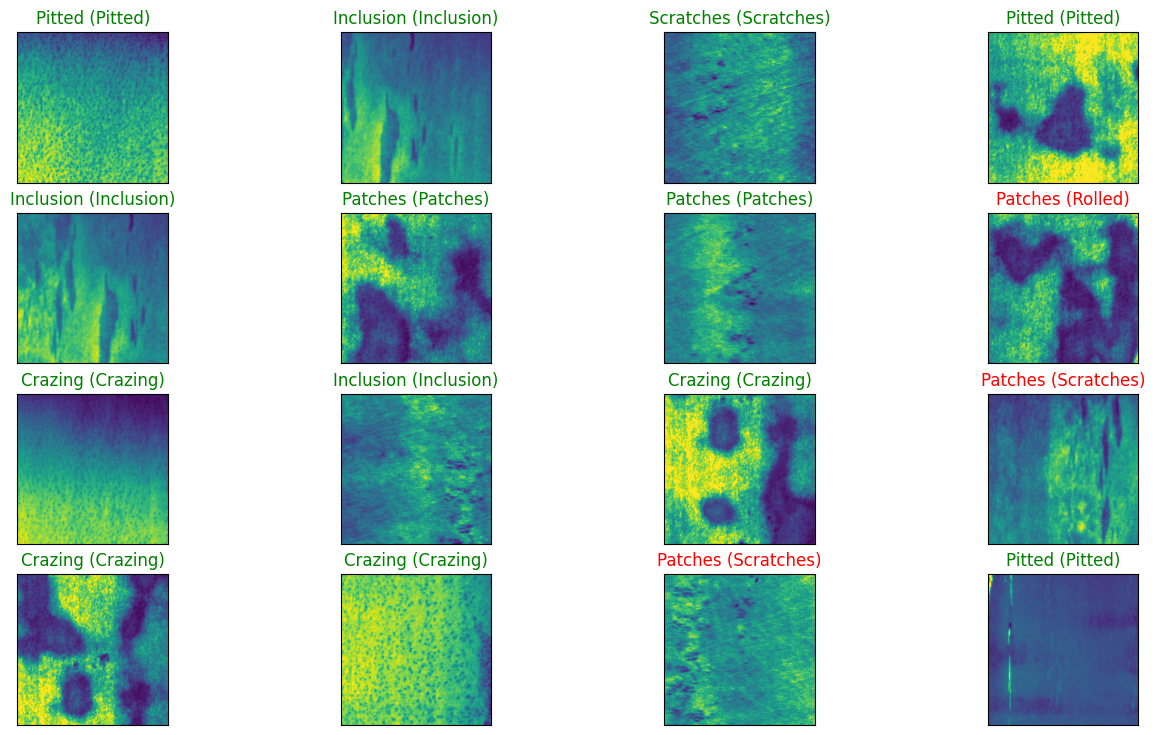

In [ ]:


import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


# Data Augmentation for Better Generalization

datagen = ImageDataGenerator(
    rotation_range=20, # Rotate image by 20 degrees
    width_shift_range=0.2, # Shift image horizontally by 20%
    height_shift_range=0.2, # Shift image up or down by 20%
    horizontal_flip=True, # Flip image horizontally
    rescale=1./255  # Normalize pixel values
)

# Load train & validation datasets
train_dir = r'C:\minor\NEU Metal Surface Defects Data\train'
val_dir = r'C:\minor\NEU Metal Surface Defects Data\valid'

train_generator = datagen.flow_from_directory( #automatically loads images from folder and applies data augmentation
    train_dir, #loads images from train folder
    target_size=(200, 200), #resize images to 200x200
    batch_size=32, #load 32 images at a time
    class_mode='categorical' #multiple classes of metal surface defects, so categorical
)
validation_generator = datagen.flow_from_directory(
    val_dir, #loads images from valid folder
    target_size=(200, 200), 
    batch_size=32, 
    class_mode='categorical'
)


# Load Pretrained VGG16 as Feature Extractor

vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=(200, 200, 3)) #200x200 images with 3 channels (rgb)
feature_extractor = tf.keras.models.Sequential([
    vgg16,
    tf.keras.layers.GlobalAveragePooling2D()  #This reduces the extracted features into a single vector for each image.
                                              #Instead of keeping a big matrix of features, it takes the average value of all feature maps,
                                              # making the output simpler and smaller, they can be used for training an SVM later.
])


# Extract Features from CNN

def extract_features(generator):
    X, y = [], [] # x will store extracted features, y will store labels(category image belongs to)
    for images, labels in generator: #generator will load images n their labels in batches
        X.append(feature_extractor.predict(images)) #extract features from images using VGG16 n added to x
        y.append(labels) #labels added to y
        if len(X) * generator.batch_size >= generator.samples: #check if all images are processed
            break
    return np.vstack(X), np.vstack(y) # convert x,y into numpy arrays

X_train, y_train = extract_features(train_generator)
X_val, y_val = extract_features(validation_generator)

# Convert labels to single-class integers, easier to use for training the SVM
y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)


# Standardize Features

scaler = StandardScaler() #Without scaling, some features may dominate others if they have larger numerical values
                          #Standardization ensures fair comparison between features.
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)


# Train SVM with RBF Kernel

# kernal is a mathematical fn that transforms data to make it easier to classify
# it can handle non-linear data
svm_model = SVC(kernel='rbf', 
                C=0.5, #C controls how much misclassification the model allows. A lower C gives a smoother decision boundary, while a higher C makes the model strict.
                gamma=0.005, #gamma controls how far the influence of a training point reaches. A lower gamma makes the decision boundary smoother, while a higher gamma makes it very tight and complex."
                probability=True
                )  
svm_model.fit(X_train, y_train)


# Evaluate Model

y_pred = svm_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"SVM Classification Accuracy: {accuracy:.2f}")


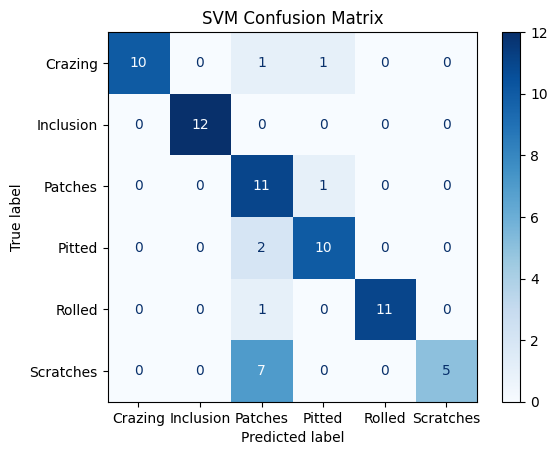

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_val, y_pred)

# Display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title("SVM Confusion Matrix")
plt.show()


In [ ]:
#SVM +GA

import tensorflow as tf
import numpy as np
import random
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score



# Load Pretrained VGG16 for Feature Extraction
vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=(200, 200, 3))
feature_extractor = tf.keras.models.Sequential([vgg16, tf.keras.layers.GlobalAveragePooling2D()])

def extract_features(generator):
    X, y = [], []
    for images, labels in generator:
        X.append(feature_extractor.predict(images))
        y.append(labels)
        if len(X) * generator.batch_size >= generator.samples:
            break
    return np.vstack(X), np.argmax(np.vstack(y), axis=1)

X_train, y_train = extract_features(train_generator)
X_val, y_val = extract_features(validation_generator)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)


# Genetic Algorithm

pop_size = 10  # Population size
generations = 5  # Number of generations
C_range = (0.1, 10)  # Regularization parameter
gamma_range = (0.0001, 0.01)  # Kernel coefficient

def fitness_function(params):
    C, gamma = params
    model = SVC(kernel='rbf', C=C, gamma=gamma)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    # Penalize too high accuracy (>90%) to avoid overfitting
    return acc if acc <= 0.88 else 0.88 - (acc - 0.88)

# Initialize population
population = [(random.uniform(*C_range), random.uniform(*gamma_range)) for _ in range(pop_size)]

for gen in range(generations):
    fitness_scores = [fitness_function(params) for params in population]
    sorted_population = [x for _, x in sorted(zip(fitness_scores, population), reverse=True)]
    population = sorted_population[:5]  # Keep top 5
    offspring = [(random.uniform(*C_range), random.uniform(*gamma_range)) for _ in range(5)]  # New random individuals
    population += offspring  # Merge top 5 + new 5
    print(f"Generation {gen+1}: Best Accuracy = {max(fitness_scores):.4f}")

best_params = sorted_population[0]
print(f"Optimal Hyperparameters: C={best_params[0]}, gamma={best_params[1]}")

# Final SVM with best parameters
svm_model = SVC(kernel='rbf', C=best_params[0], gamma=best_params[1])
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_val)
final_acc = accuracy_score(y_val, y_pred)
print(f"Final SVM Accuracy: {final_acc:.4f}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 